In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib


sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)


from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import display

## Importo data

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [3]:
secopI_filter = secop_I.filter(items=['id_modalidad','estado_del_proceso','id_objeto_a_contratar','tipo_de_contrato',
                                      'departamento_ejecucion','municipios_ejecucion_','cuantia_proceso','id_grupo',
                                      'id_familia','id_clase','plazo_de_ejec_del_contrato_','tiempo_adiciones_en_dias','dias_ejec_final_contrato'
                                      ])
secopI_filter.head(5)

,id_modalidad,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,municipios_ejecucion_,cuantia_proceso,id_grupo,id_familia,id_clase,plazo_de_ejec_del_contrato_,tiempo_adiciones_en_dias
0,13,celebrado,50000000,suministro,cundinamarca,facatativa,50000000,E,5022,502213,330,0
1,12,celebrado,53000000,prestacion de servicios,bogota,bogota,22980096902,E,5310,531027,660,30
2,12,celebrado,55000000,prestacion de servicios,bogota,bogota,35998452,E,5510,551015,31,40
3,12,liquidado,72000000,prestacion de servicios,bogota,bogota,16767536,F,7210,721015,170,0
4,19,celebrado,73000000,no encontrado en hoja proceso,bogota,bogota,0,F,7318,731810,360,0


In [4]:
secopI_filter['estado_del_proceso'] = secopI_filter['estado_del_proceso'].astype('category')
secopI_filter['tipo_de_contrato'] = secopI_filter['tipo_de_contrato'].astype('category')
secopI_filter['departamento_ejecucion'] = secopI_filter['departamento_ejecucion'].astype('category')
secopI_filter['id_grupo'] = secopI_filter['id_grupo'].astype('category')
secopI_filter['id_familia'] = secopI_filter['id_familia'].astype('category')
secopI_filter['id_clase'] = secopI_filter['id_clase'].astype('category')
secopI_filter['plazo_de_ejec_del_contrato_'] = secopI_filter['plazo_de_ejec_del_contrato_'].astype('category')

## Preprocesamiento - Pipeline y ColumnTransformer


Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas ColumnTransformer(). La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento .fit().

Aplicar las transformaciones aprendidas a cualquier conjunto de datos .transform().

In [5]:
numeric_cols = secopI_filter.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = secopI_filter.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

secopI_filter_prep = preprocessor.fit_transform(secopI_filter)

In [6]:
secopI_filter_prep.head(3)

,id_modalidad,id_objeto_a_contratar,cuantia_proceso,tiempo_adiciones_en_dias,estado_del_proceso_adjudicado,estado_del_proceso_borrador,estado_del_proceso_celebrado,estado_del_proceso_convocado,estado_del_proceso_descartado,estado_del_proceso_liquidado,estado_del_proceso_terminado sin liquidar,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,tipo_de_contrato_otro tipo de contrato,tipo_de_contrato_prestacion de servicios,tipo_de_contrato_suministro,departamento_ejecucion_amazonas,departamento_ejecucion_antioquia,departamento_ejecucion_arauca,departamento_ejecucion_atlantico,departamento_ejecucion_bogota,departamento_ejecucion_bolivar,departamento_ejecucion_boyaca,departamento_ejecucion_caldas,departamento_ejecucion_caqueta,departamento_ejecucion_casanare,departamento_ejecucion_cauca,departamento_ejecucion_cesar,departamento_ejecucion_choco,departamento_ejecucion_colombia,departamento_ejecucion_cordoba,departamento_ejecucion_cundinamarca,departamento_ejecucion_huila,departamento_ejecucion_la guajira,departamento_ejecucion_magdalena,departamento_ejecucion_meta,departamento_ejecucion_narino,departamento_ejecucion_norte de santander,departamento_ejecucion_otros paises,departamento_ejecucion_putumayo,departamento_ejecucion_quindio,departamento_ejecucion_risaralda,departamento_ejecucion_san andres,departamento_ejecucion_santander,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,municipios_ejecucion__abejorral,municipios_ejecucion__acacias,municipios_ejecucion__acevedo,municipios_ejecucion__agua de dios,municipios_ejecucion__aguachica,municipios_ejecucion__aguada,municipios_ejecucion__aguadas,municipios_ejecucion__albania,municipios_ejecucion__alejandria,municipios_ejecucion__algarrobo,municipios_ejecucion__almeida,municipios_ejecucion__ambalema,municipios_ejecucion__andes,municipios_ejecucion__anserma,municipios_ejecucion__anzoategui,municipios_ejecucion__apartado,municipios_ejecucion__aranzazu,municipios_ejecucion__arauca,municipios_ejecucion__arboletes,municipios_ejecucion__armenia,municipios_ejecucion__armero,municipios_ejecucion__baranoa,municipios_ejecucion__barbosa,municipios_ejecucion__barrancabermeja,municipios_ejecucion__barranquilla,municipios_ejecucion__belalcazar,municipios_ejecucion__belen de umbria,municipios_ejecucion__bello,municipios_ejecucion__betulia,municipios_ejecucion__bogota,municipios_ejecucion__bolivar,municipios_ejecucion__boyaca,municipios_ejecucion__bucaramanga,municipios_ejecucion__buenaventura,municipios_ejecucion__buenavista,municipios_ejecucion__caicedonia,municipios_ejecucion__cajamarca,municipios_ejecucion__calarca,municipios_ejecucion__cali,municipios_ejecucion__caloto,municipios_ejecucion__caqueza,municipios_ejecucion__cartagena,municipios_ejecucion__cartago,municipios_ejecucion__caucasia,municipios_ejecucion__chaparral,municipios_ejecucion__chipaque,municipios_ejecucion__chiquinquira,municipios_ejecucion__chiquiza san pedro de iguaque,municipios_ejecucion__choconta,municipios_ejecucion__cienaga,municipios_ejecucion__ciudad bolivar,municipios_ejecucion__colombia,municipios_ejecucion__colon,municipios_ejecucion__combita,municipios_ejecucion__cordoba,municipios_ejecucion__corinto,municipios_ejecucion__corozal,municipios_ejecucion__cucutilla,municipios_ejecucion__cuitiva,municipios_ejecucion__dosquebradas,municipios_ejecucion__duitama,municipios_ejecucion__el banco,municipios_ejecucion__el espinal,municipios_ejecucion__el guamo,municipios_ejecucion__el libano,municipios_ejecucion__el penon,municipios_ejecucion__el tablon de gomez,municipios_ejecucion__facatativa,municipios_ejecucion__falan,municipios_ejecucion__florencia,municipios_ejecucion__floridablanca,municipios_ejecucion__fresno,municipios_ejecucion__frontino,municipios_ejecucion__funza,municipios_ejecucion__

### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, *train* que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y *test* para comprobar el rendimiento de los modelos que representa el 20% restante.  

In [7]:
# conjunto de datos train
train_datos = secopI_filter_prep.sample(frac=0.9, random_state=0)
# conjunto de datos test
test_datos = secopI_filter_prep.drop(train_datos.index)

## Modelos Regresión

In [21]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(train_datos, 
          # pca=True,
          target = 'tiempo_adiciones_en_dias', 
          feature_selection=True, 
          fold=5, train_size= 0.8,
          preprocess=True,
          session_id = 123)
models()

,Description,Value
0,Session id,123
1,Target,tiempo_adiciones_en_dias
2,Target type,Regression
3,Original data shape,"(23898, 1920)"
4,Transformed data shape,"(23898, 384)"
5,Transformed train set shape,"(19118, 384)"
6,Transformed test set shape,"(4780, 384)"
7,Numeric features,1919
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [22]:
# compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1827,0.6972,0.8284,0.3286,0.2252,0.8531,0.2940
gbr,Gradient Boosting Regressor,0.1766,0.7124,0.8374,0.3140,0.2225,0.7365,1.2240
catboost,CatBoost Regressor,0.1734,0.7237,0.8432,0.3049,0.2231,0.7688,1.0680
rf,Random Forest Regressor,0.1513,0.7739,0.8716,0.2574,0.2310,0.6217,6.4380
knn,K Neighbors Regressor,0.1551,0.7743,0.8749,0.2486,0.2356,0.6061,0.6520
xgboost,Extreme Gradient Boosting,0.1689,0.8266,0.9037,0.1991,0.2360,0.7476,4.6460
et,Extra Trees Regressor,0.1469,0.9094,0.9466,0.1208,0.2424,0.5858,9.4140
omp,Orthogonal Matching Pursuit,0.2502,0.8989,0.9446,0.1179,0.2461,1.2193,0.3620
br,Bayesian Ridge,0.2691,0.8986,0.9444,0.1179,0.2473,1.3732,0.4360
ridge,Ridge Regression,0.2728,0.9051,0.9479,0.1102,0.2501,1.4102,0.6560


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## Analyze Model
The plot_model function is used to analyze the performance of a trained model on the test set. It may require re-training the model in certain cases.

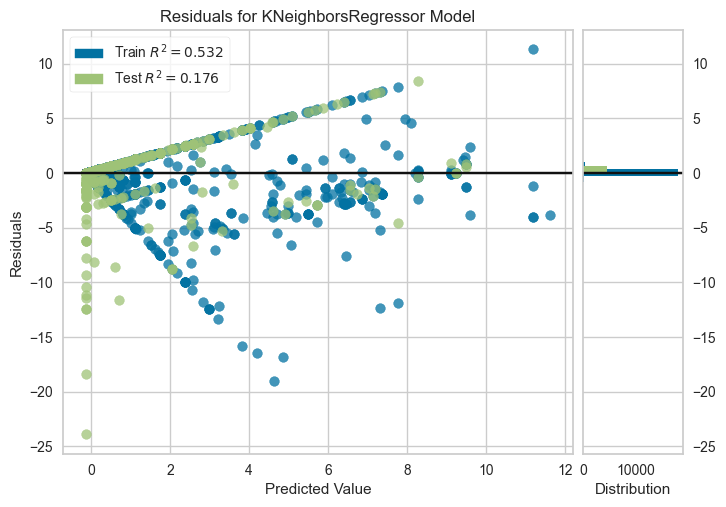

In [13]:
# plot residuals
plot_model(best, plot = 'residuals')

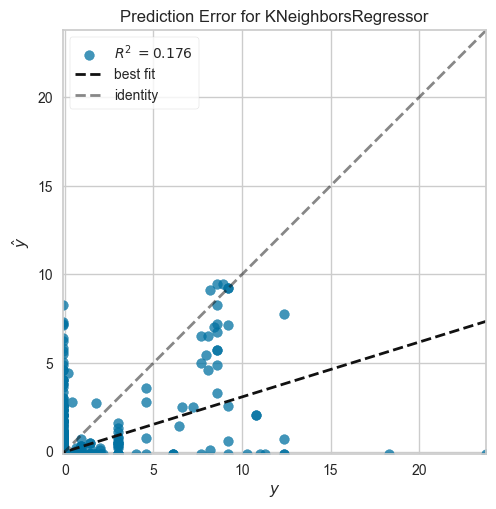

In [14]:
# plot error
plot_model(best, plot = 'error')

In [17]:
# plot feature importance
# plot_model(best, plot = 'feature')

In [19]:
print(best)

KNeighborsRegressor(n_jobs=-1)
